In [12]:
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [33]:
data_file_name_train = "reliance_train_data"
data_file_name_validate = "reliance_validate_data"
data_file_name_test = "reliance_test_data"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv( data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv( data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_name_test + "." + data_file_ext)

In [34]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (3533, 6)
Validation Dataset Shape: (757, 6)
Testing Dataset Shape: (758, 6)


In [35]:
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
         Date       Open       High        Low      Close     Volume
0  03-01-2005  37.420300  37.499429  36.728795  37.114112   96188867
1  04-01-2005  36.553333  37.843450  36.439802  37.843450   73639782
2  05-01-2005  36.463890  36.704714  35.514366  36.192108  112450407
3  06-01-2005  36.205864  36.914567  35.934075  36.329713   91978134
4  07-01-2005  37.310204  37.685199  36.298753  36.811360  108134977
Validation Dataset:
         Date        Open        High         Low       Close    Volume
0  03-05-2019  635.936584  639.841122  633.138004  635.530348  14240262
1  06-05-2019  625.125916  633.205754  622.056451  631.039098  15832114
2  07-05-2019  606.438477  629.684909  604.948882  629.594634  19417647
3  08-05-2019  586.554871  604.858605  583.282318  604.858605  31958919
4  09-05-2019  567.145264  581.747610  565.023745  581.747610  42670173
Testing Dataset:
         Date         Open         High          Low        Close    Volume
0  24-05-2022  1203.288

In [36]:
print("\nTraining Dataset Columns:")
print(data_train_df.columns)
print("\nValidation Dataset Columns:")
print(data_validate_df.columns)
print("\nTesting Dataset Columns:")
print(data_test_df.columns)


Training Dataset Columns:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Validation Dataset Columns:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

Testing Dataset Columns:
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')


In [39]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"], format="%d-%m-%Y")
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"], format="%d-%m-%Y")
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"], format="%d-%m-%Y")

In [40]:
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [41]:
print(data_train_df.columns.tolist())


['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


In [91]:
features = ["Open", "High", "Low",	"Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

In [92]:
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

In [93]:

# Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

In [94]:
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [95]:
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (5048, 5)

 Data Train Scaled: (3533, 5)
> Data Train X: (3473, 60, 5)
> Data Train y: (3473,)

 Data Validate Scaled: (757, 5)
> Data Validate X: (757, 60, 5)
> Data Validate y: (757,)

 Data Test Scaled: (758, 5)
> Data Test X: (758, 60, 5)
> Data Test y: (758,)


In [96]:
# Initializing the model
regressor = Sequential()

In [97]:
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [98]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [99]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [100]:
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [101]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [102]:
regressor.add(Dense(units = 1))

In [103]:
regressor.compile(optimizer = "adam", loss="mean_squared_error")

In [104]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_name = "reliance_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
     model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [105]:
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 243ms/step - loss: 60556.5742 - val_loss: 777970.3750
Epoch 2/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - loss: 57213.1211 - val_loss: 767543.8750
Epoch 3/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - loss: 54751.2305 - val_loss: 757942.4375
Epoch 4/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - loss: 52151.4805 - val_loss: 748410.0000
Epoch 5/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - loss: 51593.8359 - val_loss: 739229.9375
Epoch 6/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 231ms/step - loss: 47352.8594 - val_loss: 730390.9375
Epoch 7/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 239ms/step - loss: 45004.7344 - val_loss: 721810.8750
Epoch 8/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - loss: 44646.4727 - val_loss: 713379.5625
Epoch 9/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 20s 237ms/step - loss: 41681.1836 - val_loss: 705174.0000
Epoch 10/200
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - loss: 38846.6094 - val_loss: 697153.1250
Epoch 11/200
55/55 ━━━━━━━━━━

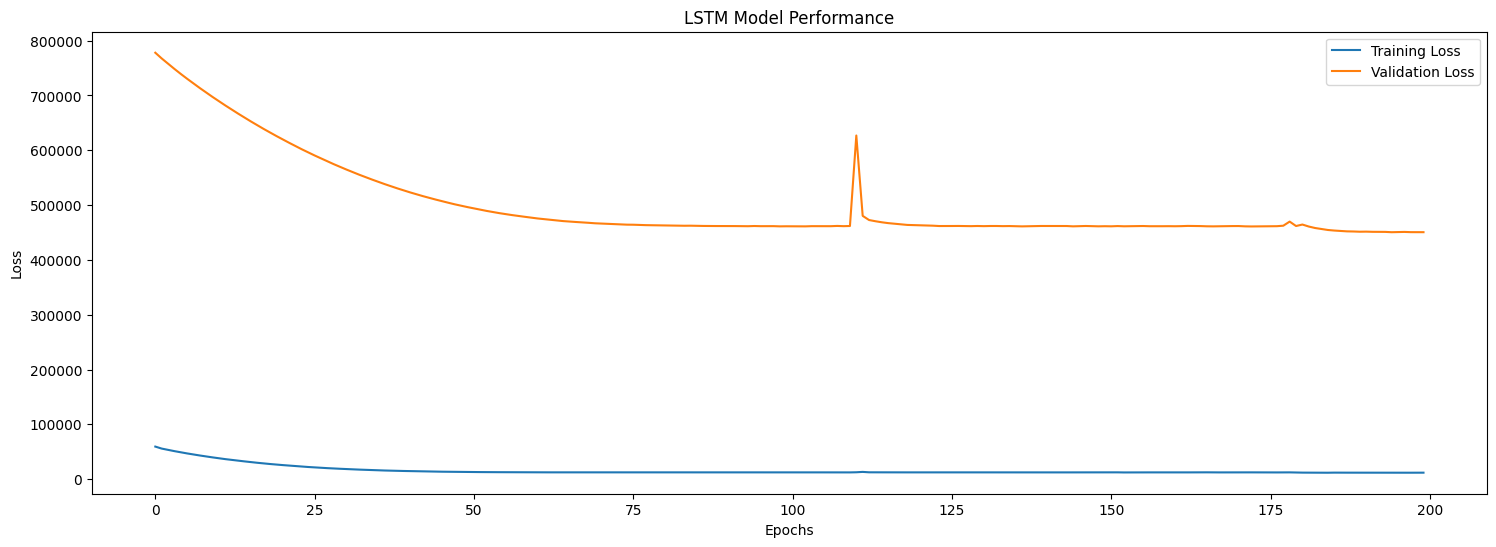

In [106]:
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [107]:

# Prepare model location and name
model_name = "reliance_stock_price_lstm.model.keras"

# Load the best performing model
best_model = load_model( model_name)

In [108]:

# Predict stock price for all data splits
y_train_predict = best_model.predict(X_train)
y_validate_predict = best_model.predict(X_validate)
y_test_predict = best_model.predict(X_test)

109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [112]:
from sklearn.preprocessing import MinMaxScaler
# Prepare data file location and name
data_file_name = "reliance_recent_data"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_name + "." + data_file_ext)
scaler = MinMaxScaler()
scaler.fit(data[features])
scaled_data = scaler.transform(data[features])
scaled_df = pd.DataFrame(scaled_data, columns=features)
import joblib
joblib.dump(scaler, 'reliance_stock_price_scaler.gz')

['reliance_stock_price_scaler.gz']

In [113]:
scaler_model_name = "reliance_stock_price_scaler"
scaler_model_ext = "gz"

# Store the scaler model
sc = joblib.load(scaler_model_name + "." + scaler_model_ext)

In [115]:
# Restore actual distribution for predicted prices
# Create placeholder arrays with the correct number of features (5)
placeholder_train = np.zeros((len(y_train), len(features)))
placeholder_validate = np.zeros((len(y_validate), len(features)))
placeholder_test = np.zeros((len(y_test), len(features)))

placeholder_train_predict = np.zeros((len(y_train_predict), len(features)))
placeholder_validate_predict = np.zeros((len(y_validate_predict), len(features)))
placeholder_test_predict = np.zeros((len(y_test_predict), len(features)))

# Place the actual/predicted values in the correct column (index 0, for 'Open')
placeholder_train[:, 0] = y_train
placeholder_validate[:, 0] = y_validate
placeholder_test[:, 0] = y_test

placeholder_train_predict[:, 0] = y_train_predict.flatten() # Flatten because predict returns (n_samples, 1)
placeholder_validate_predict[:, 0] = y_validate_predict.flatten()
placeholder_test_predict[:, 0] = y_test_predict.flatten()


# Apply inverse transform to the placeholder arrays and extract the unscaled target column
y_train_inv = sc.inverse_transform(placeholder_train)[:, 0]
y_validate_inv = sc.inverse_transform(placeholder_validate)[:, 0]
y_test_inv = sc.inverse_transform(placeholder_test)[:, 0]

y_train_predict_inv = sc.inverse_transform(placeholder_train_predict)[:, 0]
y_validate_predict_inv = sc.inverse_transform(placeholder_validate_predict)[:, 0]
y_test_predict_inv = sc.inverse_transform(placeholder_test_predict)[:, 0]

In [116]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

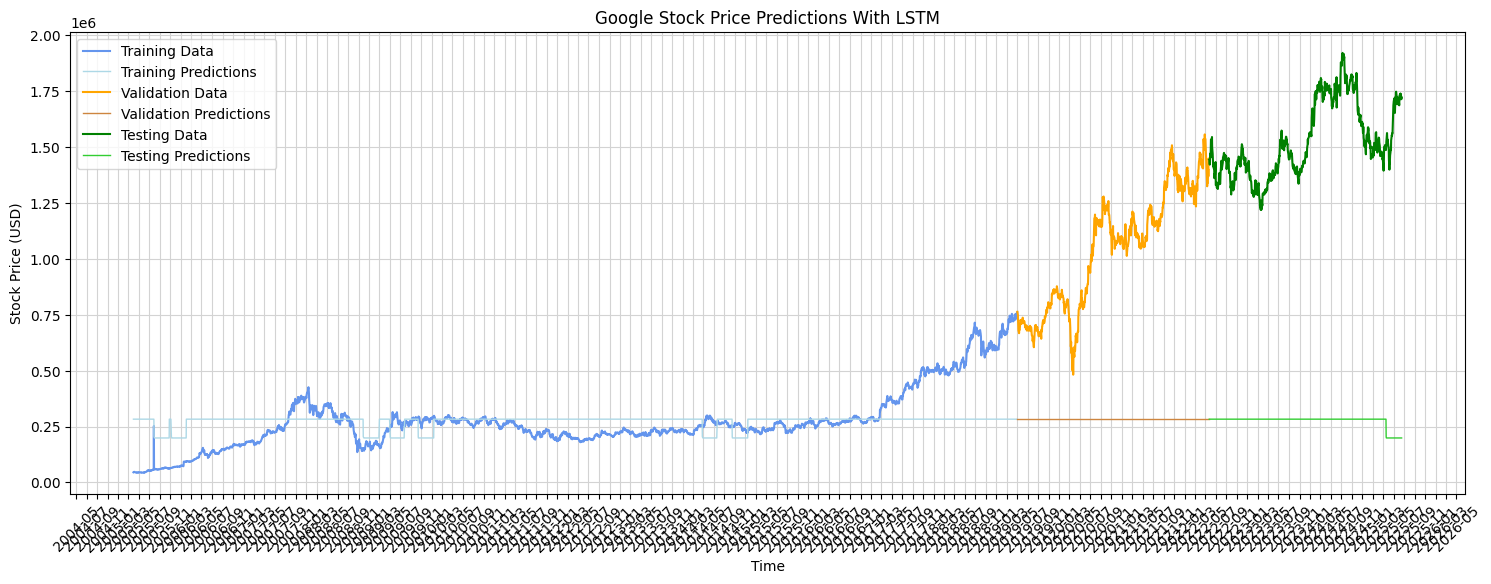

In [117]:
#Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[sequence_size:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[sequence_size:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("Reliance Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (INR)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")

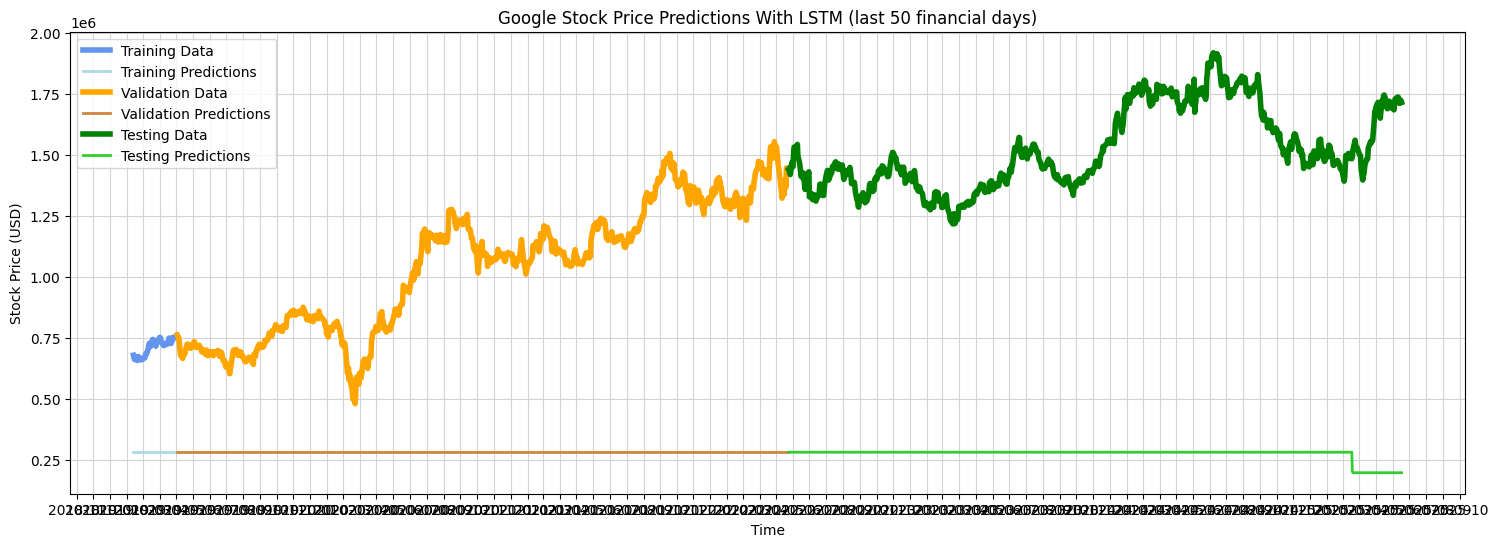

In [118]:
recent_samples = 50
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[-recent_samples:,], y_train_inv[-recent_samples:,], label="Training Data", color=train_actual_color, linewidth=4)
plt.plot(data_train_dates[-recent_samples:,], y_train_predict_inv[-recent_samples:,], label="Training Predictions", linewidth=2, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color, linewidth=4)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=2, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color, linewidth=4)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=2, color=test_predicted_color)

plt.title("Reliance Stock Price Predictions With LSTM (last 50 financial days)")
plt.xlabel("Time")
plt.ylabel("Stock Price (INR)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")